In [ ]:
! pip install pmdarima
! pip install statsmodels

## Import

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict
from statsmodels.tsa.stattools import adfuller, acf, pacf, arma_order_select_ic, kpss
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.deterministic import Fourier
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.arima_process import arma_generate_sample, ArmaProcess
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from statsmodels.stats.stattools import jarque_bera
from statsmodels.tsa.stattools import grangercausalitytests
import statsmodels.api as sm
from statsmodels.tsa.vector_ar.vecm import coint_johansen

# rom scipy.stats import shapiro

import pmdarima as pm

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit

warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=UserWarning)

sns.set(style='darkgrid')
sns.mpl.rc('figure', figsize=(7, 5))
sns.mpl.rc('font', size = 12)

pd.set_option('display.max_columns', 100)

# Usefull function and classes

In [193]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


def display_error(y, y_predict, decimals=3, full=False):
    if full:
        print(f"Mean Squared Error: \t\t{mean_squared_error(y, y_predict)}")
        #print(f"Mean Absolute Error: \t\t{mean_absolute_error(y, y_predict)}")
        print(f"Mean Absolute Percentage Error: {mean_absolute_percentage_error(y, y_predict)}%")
        
    else:
        print(f"Mean Squared Error: \t\t{mean_squared_error(y, y_predict):.{decimals}f}")
        #print(f"Mean Absolute Error: \t\t{mean_absolute_error(y, y_predict):.{decimals}f}")
        print(f"Mean Absolute Percentage Error: {mean_absolute_percentage_error(y, y_predict):.3f}%")
     
     
# 1. Function to check stationarity (Augmented Dickey-Fuller Test)
def check_stationarity(df, significance=0.05):
    """ Returns a dictionary classifying each column as I(0), I(1), or I(2). """
    stationarity = {}
    for col in df.columns:
        series = df[col].dropna()
        result_0 = adfuller(series)
        if result_0[1] < significance:
            stationarity[col] = 'I(0)'
        else:
            series_diff1 = series.diff().dropna()
            result_1 = adfuller(series_diff1)
            if result_1[1] < significance:
                stationarity[col] = 'I(1)'
            else:
                series_diff2 = series_diff1.diff().dropna()
                result_2 = adfuller(series_diff2)
                stationarity[col] = 'I(2)' if result_2[1] < significance else 'I(3)'
    return stationarity


# 2. Function to difference non-stationary series
def make_stationary(df, stationarity_info):
    """ Differentiates I(1) or I(2) series to make them stationary. """
    df_diff = df.copy()
    for col, order in stationarity_info.items():
        if order == 'I(1)':
            df_diff[col] = df_diff[col].diff()
        elif order == 'I(2)':
            df_diff[col] = df_diff[col].diff().diff()
    return df_diff.dropna()



def revert_differencing(forecast_df, original_df, stationarity_info):
    """ Reconstructs forecasted values by reversing the differencing process. """
    reverted = forecast_df.copy()
    for col, order in stationarity_info.items():
        if order == 'I(1)':
            reverted[col] = original_df[col].iloc[-1] + reverted[col].cumsum()
        elif order == 'I(2)':
            first_diff = original_df[col].diff().dropna()
            reverted[col] = original_df[col].iloc[-1] + first_diff.iloc[-1] + reverted[col].cumsum().cumsum()
    return reverted



def create_lagged_exog(df, max_lag, exclude_cols = []):
    """
    Creates lagged versions of each column in df up to max_lag.
    """
    df_lags = pd.concat(
        [df.drop(
            columns = exclude_cols
        ).shift(i).add_suffix(f"_lag{i}") for i in range(1, max_lag+1)],
        axis=1
    ).dropna()
    return df_lags



def johansen_cointegration_test(df):   

    result = coint_johansen(df, det_order=0, k_ar_diff=1)
    trace_stat = result.lr1
    crit_values = result.cvt[:, 1]  # 5% critical values

    print("Johansen Cointegration Test Results:")
    for i in range(len(trace_stat)):
        print(f"Rank {i}: Trace Stat = {trace_stat[i]}, Critical Value (5%) = {crit_values[i]}")
    
    num_cointegrated = sum(trace_stat > crit_values)
    print(f"Number of cointegrating relationships: {num_cointegrated}")
    return num_cointegrated


   
def dummy_creation(df : pd.DataFrame, break_date : pd.Timestamp,
                   cols : list = []):
    df_dummy = df.copy()
    df.index = pd.to_datetime(df.index)
    df_dummy['Dummy'] =(df.index > break_date).astype(int)
    
    if len(cols) > 0:
        for col in cols:
            try:
                df_dummy[f"Dummy_{col}"] = df[col] * df_dummy['Dummy']
            except KeyError:
                print(f"Column {col} not found")
    
    return df_dummy   
   
   
    
def sarima_best_parameters(y : pd.DataFrame, X : pd.DataFrame, 
                           stationarity : dict, test_size : int = 12, title : str = "",
                           save_img = False, save_txt = False,
                           **kargs):
    
    if X is not None:
        y = y.dropna()
        X = X.dropna()

        common_index = y.index.intersection(X.index)
        y = y.loc[common_index]
        X = X.loc[common_index]
    
    train_size = len(y) - test_size
    y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]
    
    if X is not None:
        X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
    else:
        X_train, X_test = None, None
        
    print(f"Train size: {len(y_train)}")
    
    best_models = {}
    
    for i, column in enumerate(y.columns):
        print(f"Finding best parameters for {column}")
        
        if X_train is not None:
            model = pm.auto_arima(y_train[column], X = X_train[column], 
                                    d=stationarity[column],
                                    trace = False, stepwise=True, suppress_warnings=True, 
                                    error_action="ignore", n_jobs=-1,
                                    **kargs
            )
        else:
            model = pm.auto_arima(y_train[column], 
                                    d=stationarity[column],
                                    trace = False, stepwise=True, suppress_warnings=True, 
                                    error_action="ignore", n_jobs=-1, 
                                    **kargs
            )
            
        best_models[column] = model
    
    print()
    for column in y.columns:
        model = best_models[column]
        print(f"The best model for {column} is {model.order}, {model.seasonal_order}")
    print()
     
    ##############################
    # Writing summary in a file
    
    if save_txt:
    
        if not os.path.exists("txt"):
            os.makedirs("txt")
        
        with open(f"txt/{title}.txt", "w") as f:
            f.write(f"Summary for {title}\n\n")
            for column in y.columns:
                model = best_models[column]
                f.write(f"The best model for {column} is {model.order}, {model.seasonal_order}\n\n")
                f.write(model.summary().as_text())
                f.write("\n\n")      
     
     
    ################################ 
    # Forecasting
    
    predictions = {}
    conf_intervals = {}

    for column, model in best_models.items():
        if X_test is not None:
            forecast, conf_int = model.predict(n_periods=len(y_test), X=X_test[column], return_conf_int=True, alpha=0.05)
        else:
            forecast, conf_int = model.predict(n_periods=len(y_test), return_conf_int=True, alpha=0.05)
            
        predictions[column] = forecast
        conf_intervals[column] = conf_int
        print(f"Predictions for {column}")
        display_error(y_test[column], forecast, decimals=5)

    df_predictions = pd.DataFrame(predictions)

    conf_dfs = []
    for column, conf in conf_intervals.items():
        conf_df = pd.DataFrame(conf, columns=[(column, "lower"), (column, "upper")])
        conf_df.index = y_test.index
        conf_dfs.append(conf_df)
        
    df_conf = pd.concat(conf_dfs, axis=1)
    df_conf.columns = pd.MultiIndex.from_tuples(df_conf.columns)

    ###############################


    plt.figure(figsize=(8, 4))
    ax = plt.gca()
    ax.set_title(title)
    ax.set_xlabel("Date")
    ax.set_ylabel("Share of Savings [%]")
    
    
    df_predictions.plot(ax = ax, label='Predictions')
    y.plot(ax = ax)

    for column in y.columns:
        lower = (column, 'lower')
        upper = (column, 'upper')
        ax.fill_between(df_conf.index, df_conf[lower], df_conf[upper], color='k', alpha=0.1)

    handles, labels = ax.get_legend_handles_labels()
    unique_labels = dict(zip(labels, handles))
    ax.legend(unique_labels.values(), unique_labels.keys())
    
    if save_img:
        if not os.path.exists("imgs"):
                os.makedirs("imgs")
        plt.savefig(os.path.join("imgs", f"{title}.png"))
    plt.show()
    
    
    ##############################
    
    # Plotting them independently    
    plt.figure(figsize=(12, 8))
    plt.suptitle(title)
    for i, column in enumerate(y.columns):
        plt.subplot(3, 2, i+1)
        plt.title(column)
        plt.plot(y[column], label='True')
        plt.plot(predictions[column], label='Predictions')
        plt.fill_between(y_test.index, conf_intervals[column][:, 0], conf_intervals[column][:, 1], alpha=0.1)
        plt.ylabel("Share of Savings [%]")
        plt.xlabel("Date")
        plt.legend()
    plt.tight_layout()
    
    if save_img:
        if not os.path.exists("imgs"):
                os.makedirs("imgs")
        plt.savefig(os.path.join("imgs", f"{title}_multiple.png"))
    plt.show()
    
    return best_models



def sarima_chat_gpt(y: pd.DataFrame, X: pd.DataFrame, 
                    sarima_params: dict, test_size: int = 12, title: str = "",
                    save_img = False, save_txt = False,
                    **kargs):
    """
    Trains SARIMAX models with unique hyperparameters for each time series column.
    
    Parameters:
    - y : pd.DataFrame -> The dependent time series (accounts balances).
    - X : pd.DataFrame -> The exogenous variables.
    - sarima_params : dict -> Dictionary specifying SARIMA settings for each column.
        Example:
        sarima_params = {
            'CSL': {'d': 1, 'seasonal': True, 'm': 12, 'p_range': (0,3), 'q_range': (0,3)},
            'DAT': {'d': 2, 'seasonal': False, 'm': 1, 'p_range': (1,2), 'q_range': (1,2)},
        }
    - test_size : int -> Number of time steps for testing.
    - title : str -> Title for saving results.

    Returns:
    - best_models : dict -> Dictionary of fitted models.
    """
    
    if X is not None:
        y = y.dropna()
        X = X.dropna()

        # Ensure X and y have matching indices
        common_index = y.index.intersection(X.index)
        y = y.loc[common_index]
        X = X.loc[common_index]

        # Drop fully empty columns (i.e., when an account has no exogenous variables)
        X = X.dropna(axis=1, how='all')

        # Drop MultiIndex levels that became empty (if needed)
        if isinstance(X.columns, pd.MultiIndex):
            X.columns = X.columns.remove_unused_levels()
    
    train_size = len(y) - test_size
    y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

    if X is not None:
        X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
    else:
        X_train, X_test = None, None
        
    print(f"Train size: {len(y_train)}")
    
    best_models = {}
    
    for column in y.columns:
        print(f"Finding best parameters for {column}")
        
        # Get specific SARIMA settings for this column
        params = sarima_params.get(column, {})
        d_value = params.get('d', 1)
        seasonal = params.get('seasonal', True)
        m_value = params.get('m', 12)
        p_range = params.get('p_range', (0, 3))
        q_range = params.get('q_range', (0, 3))

        # Define p, q search space
        p_values = list(range(p_range[0], p_range[1] + 1))
        q_values = list(range(q_range[0], q_range[1] + 1))
        
        # Check if X_train has exogenous variables for this column
        if X_train is not None and column in X_train.columns.get_level_values(0).unique():
            exog_vars = X_train[column].dropna(axis=1, how='all')  # Remove empty exog variables
            if exog_vars.shape[1] > 0:
                model = pm.auto_arima(y_train[column], X=exog_vars, 
                                      d=d_value, seasonal=seasonal, m=m_value,
                                      #start_p=p_range[0], max_p=p_range[1],
                                      #start_q=q_range[0], max_q=q_range[1],
                                      trace=False, stepwise=True, suppress_warnings=True, 
                                      error_action="ignore", n_jobs=-1,
                                      **kargs)
            else:
                print(f"No exogenous variables for {column}, fitting without X")
                model = pm.auto_arima(y_train[column], 
                                      d=d_value, seasonal=seasonal, m=m_value,
                                      #start_p=p_range[0], max_p=p_range[1],
                                      #start_q=q_range[0], max_q=q_range[1],
                                      trace=False, stepwise=True, suppress_warnings=True, 
                                      error_action="ignore", n_jobs=-1, 
                                      **kargs)
        else:
            print(f"No exogenous variables for {column}, fitting without X")
            model = pm.auto_arima(y_train[column], 
                                  d=d_value, seasonal=seasonal, m=m_value,
                                  #start_p=p_range[0], max_p=p_range[1],
                                  #start_q=q_range[0], max_q=q_range[1],
                                  trace=False, stepwise=True, suppress_warnings=True, 
                                  error_action="ignore", n_jobs=-1, 
                                  **kargs)
        best_models[column] = model
    
    print()
    for column in y.columns:
        model = best_models[column]
        print(f"The best model for {column} is {model.order}, {model.seasonal_order}")
    print()
     
    ##############################
    # Writing summary in a file
    if save_txt:
        if not os.path.exists("txt"):
            os.makedirs("txt")
        
        with open(f"txt/{title}.txt", "w") as f:
            f.write(f"Summary for {title}\n\n")
            for column in y.columns:
                model = best_models[column]
                f.write(f"The best model for {column} is {model.order}, {model.seasonal_order}\n")
                f.write(model.summary().as_text())
                f.write("\n\n\n")      
     
    ################################ 
    # Forecasting
    
    predictions = {}
    conf_intervals = {}

    for column, model in best_models.items():
        if X_test is not None and column in X_test.columns.get_level_values(0).unique():
            exog_vars_test = X_test[column].dropna(axis=1, how='all')
            if exog_vars_test.shape[1] > 0:
                forecast, conf_int = model.predict(n_periods=len(y_test), X=exog_vars_test, return_conf_int=True, alpha=0.05)
            else:
                forecast, conf_int = model.predict(n_periods=len(y_test), return_conf_int=True, alpha=0.05)
        else:
            forecast, conf_int = model.predict(n_periods=len(y_test), return_conf_int=True, alpha=0.05)
            
        predictions[column] = forecast
        conf_intervals[column] = conf_int
        print(f"Predictions for {column}")
        display_error(y_test[column], forecast, decimals=5)

    df_predictions = pd.DataFrame(predictions)

    conf_dfs = []
    for column, conf in conf_intervals.items():
        conf_df = pd.DataFrame(conf, columns=[(column, "lower"), (column, "upper")])
        conf_df.index = y_test.index
        conf_dfs.append(conf_df)
        
    df_conf = pd.concat(conf_dfs, axis=1)
    df_conf.columns = pd.MultiIndex.from_tuples(df_conf.columns)

    ###############################

    plt.figure(figsize=(8, 4))
    ax = plt.gca()
    ax.set_title(title)
    ax.set_xlabel("Date")
    ax.set_ylabel("Share of Savings [%]")
    
    df_predictions.plot(ax=ax, label='Predictions')
    y.plot(ax=ax)

    for column in y.columns:
        lower = (column, 'lower')
        upper = (column, 'upper')
        ax.fill_between(df_conf.index, df_conf[lower], df_conf[upper], color='k', alpha=0.1)

    handles, labels = ax.get_legend_handles_labels()
    unique_labels = dict(zip(labels, handles))
    ax.legend(unique_labels.values(), unique_labels.keys())
    
    if save_img:
        if not os.path.exists("imgs"):
            os.makedirs("imgs")
        plt.savefig(os.path.join("imgs", f"{title}.png"))
    plt.show()

    ##############################
    
    # Plotting them independently    
    plt.figure(figsize=(12, 8))
    plt.suptitle(title)
    for i, column in enumerate(y.columns):
        plt.subplot(3, 2, i+1)
        plt.title(column)
        plt.plot(y[column], label='True')
        plt.plot(predictions[column], label='Predictions')
        plt.fill_between(y_test.index, conf_intervals[column][:, 0], conf_intervals[column][:, 1], alpha=0.1)
        plt.ylabel("Share of Savings [%]")
        plt.xlabel("Date")
        plt.legend()
    plt.tight_layout()
    
    if save_img:
        if not os.path.exists("imgs"):
                os.makedirs("imgs")
        plt.savefig(os.path.join("imgs", f"{title}_multiple.png"))
    plt.show()
    
    return best_models


 
def varmax_model (X_full, y, test_size, p = 1, q = 0,
                best_lag_exog = 0, max_iter = 100,
                title = ""):
    
    try:
        exclude_cols = [
            col for col in X_full.columns if "Dummy" in col.lower()
        ]
        
        X_lagged = create_lagged_exog(X_full, best_lag_exog, exclude_cols)
        Y_aligned = y.loc[X_lagged.loc[:y.index.max()].index]
    except Exception as e:
        print("Tried to get lagged values but an error was present")
        print(e)
        X_lagged = X_full
        Y_aligned = y
    
    y_stationary = check_stationarity(Y_aligned)
    Y_stationary = make_stationary(Y_aligned, y_stationary)

    x_stationary = check_stationarity(X_lagged)
    X_stationary = make_stationary(X_lagged, x_stationary)

    # aligning
    last_real_index = Y_stationary.index.max()    
    X = X_stationary.loc[:last_real_index].copy()

    # Selecting training and testing data
    X_train = X.iloc[:-test_size]
    y_train = Y_stationary.iloc[:-test_size]
    X_test = X.iloc[-test_size:]
    y_test = Y_stationary.iloc[-test_size:]
    
    X_test_extented = X_stationary.loc[X_test.index.min():]

    # Model fitting
    model = sm.tsa.VARMAX(y_train, exog=X_train, order=(p, q))
    result = model.fit(maxiter=max_iter, disp=False)
    
    
    forecast = result.forecast(steps=test_size, exog=X_test)
    y_pred = pd.DataFrame(forecast, columns=y.columns, 
                                index=y_test.index)
    
    y_pred = revert_differencing(y_pred, y.iloc[:-test_size], y_stationary)
    
    print("Mean absolute percentage error:", 
          round(
              mean_absolute_percentage_error(Y_aligned[-test_size:], y_pred)
            , 3), "%")
    
    

    forecast = result.forecast(steps=len(X_test_extented), exog=X_test_extented)
    forecast_df = pd.DataFrame(forecast, columns=y.columns, index=X_test_extented.index)

    # Revert differencing
    y_pred = revert_differencing(forecast_df, y.iloc[:-test_size], y_stationary)
    
    
    y_vline_limit = pd.concat([y, y_pred])
    
    plt.vlines(y.index[-test_size], ymin=y_vline_limit.min().min(), 
                ymax=y_vline_limit.max().max(), 
               linestyle='dashed', color='silver')
    
    plt.vlines(y.index[-1], ymin=y_vline_limit.min().min(), 
                ymax=y_vline_limit.max().max(), 
               linestyle='dashed', color='silver')
    
    plt.title(f"Predictions vs Actuals\n{title}")
    colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    for i, col in enumerate(y.columns):
        plt.plot(y.index, y[col], label=f"{col} Actual", color=colors[i % len(colors)])
        
        plt.plot(y_pred.index, y_pred[col], linestyle='dashed', label=f"{col} Predicted", color=colors[i % len(colors)])
    plt.legend(loc='lower left')
    plt.show()
    return model, result



def ardl_model (X_full, y, test_size, 
                max_lag_y = 3, max_lag_exog = 3,
                trend = 'c',
                title = ""):
    
    """ 
    'n' - No trend.
    'c' - Constant only.
    't' - Time trend only.
    'ct' - Constant and time trend.
    """

        
    if type(max_lag_exog) is not int:
        lag_col_exog = [
            max_lag_exog if 'dummy' not in col.lower() else 0 for col in X_full.columns
        ] 
    else:
        lag_col_exog = max_lag_exog
        
        
    X_lagged = X_full
    Y_aligned = y
    
    y_stationary = check_stationarity(Y_aligned)
    Y_stationary = make_stationary(Y_aligned, y_stationary)

    x_stationary = check_stationarity(X_lagged)
    X_stationary = make_stationary(X_lagged, x_stationary)

    # aligning
    X, Y_stationary = X_stationary.align(Y_stationary, join='inner', axis=0)

    # Selecting training and testing data
    X_train = X.iloc[:-test_size]
    y_train = Y_stationary.iloc[:-test_size]
    X_test = X.iloc[-test_size:]
    y_test = Y_stationary.iloc[-test_size:]
    
    X_test_extented = X_stationary.loc[X_test.index.min():]

    # Model fitting
    model = sm.tsa.ARDL(y_train, max_lag_y,
                        X_train, lag_col_exog,
                        trend=trend)
    result = model.fit()
    
    
    forecast = result.forecast(steps=test_size, exog=X_test)
    y_pred = pd.DataFrame(forecast, columns=y.columns, 
                                index=y_test.index)
    
    y_pred = revert_differencing(y_pred, y.iloc[:-test_size], y_stationary)
    
    print("Mean absolute percentage error:", 
          round(
              mean_absolute_percentage_error(Y_aligned[-test_size:], y_pred)
            , 3), "%")
    
    

    forecast = result.forecast(steps=len(X_test_extented), exog=X_test_extented)
    forecast_df = pd.DataFrame(forecast, columns=y.columns, index=X_test_extented.index)

    # Revert differencing
    y_pred = revert_differencing(forecast_df, y.iloc[:-test_size], y_stationary)
    
    
    y_vline_limit = pd.concat([y, y_pred])
    
    plt.vlines(y.index[-test_size], ymin=y_vline_limit.min().min(), 
                ymax=y_vline_limit.max().max(), 
               linestyle='dashed', color='silver')
    
    plt.vlines(y.index[-1], ymin=y_vline_limit.min().min(), 
                ymax=y_vline_limit.max().max(), 
               linestyle='dashed', color='silver')
    
    plt.title(f"Predictions vs Actuals\n{title}")
    colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    for i, col in enumerate(y.columns):
        plt.plot(y.index, y[col], label=f"{col} Actual", color=colors[i % len(colors)])
        
        plt.plot(y_pred.index, y_pred[col], linestyle='dashed', label=f"{col} Predicted", color=colors[i % len(colors)])
    plt.legend(loc='lower left')
    plt.show()
    return model, result



def sarima_model_multivariate(y: pd.DataFrame, X: pd.DataFrame,
                              test_size: int,
                              sarima_params: dict,
                              stationary_exog: bool = False,
                              title: str = "",
                              save_img: bool = False,
                              save_txt: bool = False,
                              data_percentage : bool = True,
                              **kargs):
    y = y.dropna()
    if X is not None:
        X = X.dropna()
        common_index = y.index.intersection(X.index)
        y = y.loc[common_index]
        X = X.loc[common_index]

    # Preprocess X: transform to stationary then re-align with y
    if X is not None:
        if stationary_exog:
            x_stationary_info = check_stationarity(X)
            X_stationary = make_stationary(X, x_stationary_info)
        else:
            X_stationary = X.copy()
        # Use the common index between y and X_stationary since differencing may remove the first rows
        common_index2 = y.index.intersection(X_stationary.index)
        y = y.loc[common_index2]
        X_stationary = X_stationary.loc[common_index2]
    else:
        X_stationary = None

    # Partition data using the (possibly new) common index.
    train_size = len(y) - test_size
    y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]
    if X_stationary is not None:
        X_train, X_test = X_stationary.iloc[:train_size], X_stationary.iloc[train_size:]
    else:
        X_train = X_test = None

    print(f"Train size: {len(y_train)}")
    


    best_models = {}
    forecasts = {}
    errors = {}
    
    plt.figure(figsize=(10, 6))
    colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    
    # Loop for each dependent series (column)
    for i, col in enumerate(y.columns):
        print(f"\nFitting SARIMA for {col}")
        y_col = y[[col]].copy()
        y_stationarity_info = check_stationarity(y_col)
        print(f"Stationarity for {col}: {y_stationarity_info}")
        Y_stationary = make_stationary(y_col, y_stationarity_info)

        # Align exogenous variables with this stationary series:
        if X is not None:
            X_aligned, Y_aligned = X_stationary.align(Y_stationary, join='inner', axis=0)
        else:
            Y_aligned = Y_stationary

        # Adjust train/test split based on the differenced series length:
        train_size_adjusted = len(Y_aligned) - test_size
        y_train_col = Y_aligned.iloc[:train_size_adjusted]
        y_test_col = Y_aligned.iloc[train_size_adjusted:]
        # And similarly adjust X_train_col and X_test_col if needed:
        if X is not None:
            X_train_col = X_aligned.iloc[:train_size_adjusted]
            X_test_col = X_aligned.iloc[train_size_adjusted:]
        else:
            X_train_col = X_test_col = None

        
        # For extended forecasting, we may want the exogenous variables starting from the beginning of the test set
        if X is not None:
            X_test_ext = X_aligned.loc[X_test_col.index.min():]
        else:
            X_test_ext = None
            
        # Retrieve SARIMA parameters for this series
        # Defaults if not provided: non-seasonal orders (1,1,1) and seasonal orders (0,1,1,12) if seasonal is True.
        params = sarima_params.get(col, {})
        
        auto_order = kargs.pop('auto_order', False)
        
        if not auto_order:
            p = params.get('p', 1)
            q = params.get('q', 1)
            
        d = params.get('d', 1)
        m_value = params.get('m', 12)
        seasonal = params.get('seasonal', True)
        if seasonal:
            P = params.get('P', 0)
            D = params.get('D', 1)
            Q = params.get('Q', 1)
            m_value = params.get('m', 12)
            seasonal_order = (P, D, Q, m_value)
        else:
            seasonal_order = (0, 0, 0, 0)
        

        # Fit the SARIMA model using pmdarima.auto_arima with the specified orders.
        # If exogenous variables are available for this series, include them.
        if X_train_col is not None and col in X_train_col.columns:
            exog_train = X_train_col[col]
            exog_test = X_test_col[col]
            print(f"Fitting with exogenous variables for {col}")
            if auto_order:
                model = pm.auto_arima(y_train_col[col],
                                    exogenous=exog_train,
                                    d=d,
                                    seasonal=seasonal,
                                    m=m_value,
                                    trace=False,
                                    error_action='ignore',
                                    suppress_warnings=True,
                                    stepwise=True,
                                    **kargs)
            else:
                model = pm.auto_arima(y_train_col[col],
                                    exogenous=exog_train,
                                    # Use the fixed orders provided:
                                    start_p=p, max_p=p,
                                    d=d,
                                    start_q=q, max_q=q,
                                    seasonal=seasonal,
                                    m=m_value,
                                    start_P=seasonal_order[0], max_P=seasonal_order[0],
                                    D=seasonal_order[1],
                                    start_Q=seasonal_order[2], max_Q=seasonal_order[2],
                                    trace=False,
                                    error_action='ignore',
                                    suppress_warnings=True,
                                    stepwise=True,
                                    **kargs)
        else:
            print(f"Fitting without exogenous variables for {col}")
            if auto_order:
                model = pm.auto_arima(y_train_col[col],
                                    d=d,
                                    seasonal=seasonal,
                                    m=m_value,
                                    trace=False,
                                    error_action='ignore',
                                    suppress_warnings=True,
                                    stepwise=True,
                                    **kargs)
            else:
                model = pm.auto_arima(y_train_col[col],
                                    # Use the fixed orders provided:
                                    start_p=p, max_p=p,
                                    d=d,
                                    start_q=q, max_q=q,
                                    seasonal=seasonal,
                                    m=m_value,
                                    start_P=seasonal_order[0], max_P=seasonal_order[0],
                                    D=seasonal_order[1],
                                    start_Q=seasonal_order[2], max_Q=seasonal_order[2],
                                    trace=False,
                                    error_action='ignore',
                                    suppress_warnings=True,
                                    stepwise=True,
                                    **kargs)
                
                best_models[col] = model
        
        print(f"Best model for {col} is: {model.order}, seasonal_order={model.seasonal_order}")
        
        # Forecast for test period:
        if X_test_col is not None and col in X_test_col.columns:
            exog_forecast = X_test_col[col]
            fc, conf_int = model.predict(n_periods=test_size, exogenous=exog_forecast, return_conf_int=True, alpha=0.05)
        else:
            fc, conf_int = model.predict(n_periods=test_size, return_conf_int=True, alpha=0.05)
        
        # Forecast is on the stationary scale so revert differencing if needed:
        fc_df = pd.DataFrame(fc, columns=[col], index=y_test_col.index)
        fc_reverted = revert_differencing(fc_df, y_col.iloc[:train_size], y_stationarity_info)
        forecasts[col] = fc_reverted
        
        mape = mean_absolute_percentage_error(y_col.iloc[train_size:], fc_reverted)
        errors[col] = mape
        print(f"MAPE for {col}: {round(mape, 3)}%")
        
        # Optional extended forecast (if desired):
        if X_test_ext is not None and col in X_test_ext.columns:
            exog_ext = X_test_ext[col]
            fc_ext = model.predict(n_periods=len(X_test_ext), exogenous=exog_ext)
        else:
            fc_ext = model.predict(n_periods=len(X_test_ext) if X_test_ext is not None else test_size)
        fc_ext_df = pd.DataFrame(fc_ext, columns=[col], index=(X_test_ext.index if X_test_ext is not None else y_test_col.index))
        fc_ext_reverted = revert_differencing(fc_ext_df, y_col.iloc[:train_size], y_stationarity_info)
        
        # Plot actual vs predicted
        color = colors[i % len(colors)]
        plt.plot(y.index, y[col], label=f"{col} Actual", color=color)
        plt.plot(fc_ext_reverted.index, fc_ext_reverted[col], linestyle='dashed',
                 label=f"{col} Predicted", color=color)
    
    # Add vertical lines to show test start and end points
    ax = plt.gca()
    ylim = ax.get_ylim()
    ax.vlines(y.index[train_size], ymin=ylim[0], ymax=ylim[1], linestyle='dashed', color='silver')
    ax.vlines(y.index[-1], ymin=ylim[0], ymax=ylim[1], linestyle='dashed', color='silver')
    
    if data_percentage:
        plt.ylim(max(ylim[0], 0), min(ylim[1], 0.5))
        plt.ylabel("Share of Savings [%]")
    else:
        plt.ylim(max(ylim[0], 0), min(ylim[1], 750_000))
        plt.ylabel("Price")
    plt.title(f"Predictions vs Actuals\n{title}")
    plt.legend(loc='lower left')
    plt.show()
    
    # Optionally write a text summary
    if save_txt:
        if not os.path.exists("txt"):
            os.makedirs("txt")
        with open(f"txt/{title}_sarima.txt", "w") as f:
            f.write(f"SARIMA Summary for {title}\n\n")
            for col in y.columns:
                model = best_models[col]
                f.write(f"{col}: Model {model.order}, seasonal_order={model.seasonal_order}\n")
                f.write(model.summary().as_text())
                f.write("\n\n")
    
    return best_models, forecasts, errors



def ardl_model_multivariate(X_full, y, test_size, 
                            max_lag_y=3, max_lag_exog=3,
                            trend='c',
                            title="",
                            data_percentage: bool = True):
    """
    Fits a separate ARDL model for each column in y and plots all series together.
    
    'n' - No trend.
    'c' - Constant only.
    't' - Time trend only.
    'ct' - Constant and time trend.
    """
    # Set exogenous lag orders
        

    """ if "dummy" in  "".join(X_full.columns).lower():
        lag_col_exog = [max_lag_exog if 'dummy' not in col.lower() else 1 for col in X_full.columns]
    else:
        lag_col_exog = max_lag_exog """
    
    lag_col_exog = max_lag_exog    
        
    # Compute stationarity for X only once
    x_stationary = check_stationarity(X_full)
    X_stationary = make_stationary(X_full, x_stationary)

    # Prepare dictionaries to store model objects, forecasts and errors
    models = {}
    results = {}
    forecasts = {}
    errors = {}

    plt.figure(figsize=(10, 6))
    colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

    # Loop through each column of y
    for i, col in enumerate(y.columns):
        print(f"Fitting ARDL for {col}")
        # Extract the univariate series as a DataFrame
        y_col = y[[col]].copy()

        # Compute stationarity and difference if needed for this series
        y_stationary_info = check_stationarity(y_col)
        
        #y_stationary_info[col] = 'I(1)'
        print(y_stationary_info)
        
        Y_stationary = make_stationary(y_col, y_stationary_info)

        # Align X and Y on their indexes
        X_aligned, Y_aligned = X_stationary.align(Y_stationary, join='inner', axis=0)

        # Split into training and testing sets
        X_train = X_aligned.iloc[:-test_size]
        y_train = Y_aligned.iloc[:-test_size]
        X_test = X_aligned.iloc[-test_size:]
        y_test = Y_aligned.iloc[-test_size:]
        
        # For extended forecast, we use X starting at the beginning of test period
        X_test_extended = X_stationary.loc[X_test.index.min():]

        # Fit ARDL model for this dependent variable
        model = sm.tsa.ARDL(y_train, max_lag_y, X_train, lag_col_exog, trend=trend)
        result = model.fit()
        models[col] = model
        results[col] = result

        # Forecast for the test period
        forecast = result.forecast(steps=test_size, exog=X_test)
        y_pred = pd.DataFrame(forecast, columns=[col], index=y_test.index)
        # Reverse the differencing
        y_pred_reverted = revert_differencing(y_pred, y_col.iloc[:-test_size], y_stationary_info)
        forecasts[col] = y_pred_reverted

        mape = mean_absolute_percentage_error(y_col[-test_size:], y_pred_reverted)
        errors[col] = mape
        print(f"MAPE for {col}: {round(mape, 3)}%")

        # Optional: extended forecast (if needed)
        forecast_ext = result.forecast(steps=len(X_test_extended), exog=X_test_extended)
        forecast_df = pd.DataFrame(forecast_ext, columns=[col], index=X_test_extended.index)
        y_pred_ext = revert_differencing(forecast_df, y_col.iloc[:-test_size], y_stationary_info)

        # Plot actual vs predicted on the same canvas
        color = colors[i % len(colors)]
        plt.plot(y.index, y[col], label=f"{col} Actual", color=color)
        plt.plot(y_pred_ext.index, y_pred_ext[col], linestyle='dashed',
                 label=f"{col} Predicted", color=color)
        

    # Add vertical lines to indicate forecast periods
    ax = plt.gca()
    ylim = ax.get_ylim()
    ax.vlines(y.index[-test_size], ymin=ylim[0], ymax=ylim[1],
            linestyle='dashed', color='silver')
    ax.vlines(y.index[-1], ymin=ylim[0], ymax=ylim[1],
            linestyle='dashed', color='silver')
    
    if data_percentage:
        plt.ylim(max(ylim[0], 0), min(ylim[1], 0.5))
        plt.ylabel("Share of Savings [%]")
    else:
        plt.ylim(max(ylim[0], 0), min(ylim[1], 750_000))
        plt.ylabel("Price")
    plt.title(f"Predictions vs Actuals\n{title}")
    plt.legend(loc='lower left')
    plt.show()

    return models, results



def vecm_model_vanilla(X_full, y, test_size, 
               optimal_lag_endog=3, 
               best_lag_exog=3,
               coint_rank=3,
               title="",
               deterministic='ci',
               difference=True,
               display=True,
               data_percentage: bool = True):
    """
    VECM model with optional first differencing of y and X.

    Deterministic term options:
       "n"  - no deterministic terms
       "co" - constant outside the cointegration relation
       "ci" - constant within the cointegration relation
       "lo" - linear trend outside the cointegration relation
       "li" - linear trend within the cointegration relation

    If difference=True, both y and X_full are first-differenced before modeling.
    Note: Forecasted differences are then reverted to levels using the last observed training value.
    """
    # Optionally difference the data (excluding dummy variables by assumption)
    if difference:
        # Store the original levels for later reversion
        y_orig = y.copy()
        X_orig = X_full.copy()
        y = y.diff().dropna()
        X_full = X_full.diff().dropna()
    else:
        y_orig = y.copy()
    
    # Try to create lagged exogenous variables (if any), excluding dummies if present
    try:
        exclude_cols = [col for col in X_full.columns if "Dummy" in col.lower()]
        X_lagged = create_lagged_exog(X_full, best_lag_exog, exclude_cols)
        Y_aligned = y.loc[X_lagged.loc[:y.index.max()].index]
    except Exception as e:
        print("Tried to get lagged values but an error was present")
        print(e)
        X_lagged = X_full
        Y_aligned = y

    # Use the last available index in Y_aligned to restrict X
    last_real_index = Y_aligned.index.max()    
    X = X_lagged.loc[:last_real_index].copy()

    # Split into training and testing sets
    X_train = X.iloc[:-test_size]
    y_train = Y_aligned.iloc[:-test_size]
    X_test = X.iloc[-test_size:]
    y_test = Y_aligned.iloc[-test_size:]
    
    # For extended forecast
    X_test_extented = X_lagged.loc[X_test.index.min():]
    
    # Fit the VECM model on the training data (levels are not required; we use the differenced series)
    model = sm.tsa.VECM(y_train, exog=X_train, 
                        k_ar_diff=optimal_lag_endog - 1, 
                        coint_rank=coint_rank,
                        deterministic=deterministic)
    result = model.fit()
    
    # Forecast on the test set
    forecast = result.predict(steps=test_size, exog_fc=X_test)
    y_pred_diff = pd.DataFrame(forecast, columns=y.columns, index=y_test.index)
    
    # If data were differenced, revert forecasting to the original level scale
    if difference:
        # Get the last observed level from the training period
        last_train_index = y_train.index[-1]
        last_level = y_orig.loc[last_train_index]
        # Revert the forecast by cumulatively summing the differences and adding the last level
        y_pred = y_pred_diff.cumsum() + last_level
        # Also obtain the true test values in levels from y_orig
        y_test_level = y_orig.loc[y_test.index]
    else:
        y_pred = y_pred_diff
        y_test_level = y_test

    print("Mean absolute percentage error:", 
          round(mean_absolute_percentage_error(y_test_level, y_pred), 3), "%")
    
    # Extended forecast using X_test_extented
    forecast_ext = result.predict(steps=len(X_test_extented), exog_fc=X_test_extented)
    y_pred_diff_ext = pd.DataFrame(forecast_ext, columns=y.columns, index=X_test_extented.index)
    if difference:
        last_train_index = y_train.index[-1]
        last_level = y_orig.loc[last_train_index]
        y_pred_ext = y_pred_diff_ext.cumsum() + last_level
    else:
        y_pred_ext = y_pred_diff_ext

    # Plotting actual vs. predicted values. Use original levels if differenced.
    if difference:
        actual_plot = y_orig
    else:
        actual_plot = y
        
    if display:
        y_vline_limit = pd.concat([actual_plot, y_pred])
        
        plt.vlines(actual_plot.index[-test_size], ymin=y_vline_limit.min().min(), 
                ymax=y_vline_limit.max().max(), linestyle='dashed', color='silver')
        plt.vlines(actual_plot.index[-1], ymin=y_vline_limit.min().min(), 
                ymax=y_vline_limit.max().max(), linestyle='dashed', color='silver')
        
        plt.title(f"Predictions vs Actuals\n{title}")
        colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
        for i, col in enumerate(y.columns):
            plt.plot(actual_plot.index, actual_plot[col], label=f"{col} Actual", color=colors[i % len(colors)])
            #plt.plot(y_pred.index, y_pred[col], linestyle='dashed', label=f"{col} Predicted", color=colors[i % len(colors)])
            plt.plot(y_pred_ext.index, y_pred_ext[col], linestyle='dashed', label=f"{col} Predicted", color=colors[i % len(colors)])
            
        ylim = plt.ylim()
        if data_percentage:
            plt.ylim(max(ylim[0], 0), min(ylim[1], 0.5))
            plt.ylabel("Share of Savings [%]")
        else:
            plt.ylim(max(ylim[0], 0), 750_000)
            plt.ylabel("Price")
        plt.legend(loc='lower left')
        plt.show()
    
    return model, result



def vecm_model(X_full, y, test_size, 
               optimal_lag_endog=3, 
               best_lag_exog=3,
               coint_rank=3,
               title="",
               deterministic='ci',
               difference=True,
               display=True):
    """
    VECM model with optional first differencing of y and X.

    Deterministic term options:
       "n"  - no deterministic terms
       "co" - constant outside the cointegration relation
       "ci" - constant within the cointegration relation
       "lo" - linear trend outside the cointegration relation
       "li" - linear trend within the cointegration relation

    If difference=True, both y and X_full are first-differenced before modeling.
    Forecasted differences are then reverted to levels using the last observed training value.
    """
    # Optionally difference the data (assume no dummy variables in differencing)
    if difference:
        # Store original levels for later reversion
        y_orig = y.copy()
        y = y.diff().dropna()
        X_full = X_full.diff().dropna().copy()
    else:
        y_orig = y.copy()
    
    # Try to create lagged exogenous variables (if any)
    try:
        exclude_cols = [col for col in X_full.columns if "Dummy" in col.lower()]
        X_lagged = create_lagged_exog(X_full, best_lag_exog, exclude_cols)
        Y_aligned = y.loc[X_lagged.loc[:y.index.max()].index]
    except Exception as e:
        print("Tried to get lagged values but an error was present")
        print(e)
        X_lagged = X_full
        Y_aligned = y

    # Use the last available index in Y_aligned to restrict X
    last_real_index = Y_aligned.index.max()    
    X = X_lagged.loc[:last_real_index].copy()

    # Split into training and testing sets
    X_train = X.iloc[:-test_size]
    y_train = Y_aligned.iloc[:-test_size]
    X_test = X.iloc[-test_size:]
    y_test = Y_aligned.iloc[-test_size:]
    
    # For extended forecast (not used in CV but for final forecasting)
    X_test_extented = X_lagged.loc[X_test.index.min():]
    
    # Fit the VECM model on the training data (using differenced series)
    model = sm.tsa.VECM(y_train, exog=X_train, 
                        k_ar_diff=optimal_lag_endog - 1, 
                        coint_rank=coint_rank,
                        deterministic=deterministic)
    result = model.fit()
    result.model.trend_coefs = np.real(result.model.trend_coefs)
    
    # Forecast on the test set
    forecast = result.predict(steps=test_size, exog_fc=X_test)
    forecast = np.real(forecast)
    y_pred_diff = pd.DataFrame(forecast, columns=y.columns, index=y_test.index)
    
    # Revert forecast differences back to levels if necessary
    if difference:
        last_train_index = y_train.index[-1]
        last_level = y_orig.loc[last_train_index]
        y_pred = y_pred_diff.cumsum() + last_level
        # Get true test values in levels from the original data
        y_test_level = y_orig.loc[y_test.index]
    else:
        y_pred = y_pred_diff
        y_test_level = y_test

    # Calculate forecasting metric (MAPE)
    mape_val = round(mean_absolute_percentage_error(y_test_level, y_pred), 3)
    print("Mean absolute percentage error:", mape_val, "%")
    
    
    # Extended forecast using X_test_extented
    forecast_ext = result.predict(steps=len(X_test_extented), exog_fc=X_test_extented)
    y_pred_diff_ext = pd.DataFrame(forecast_ext, columns=y.columns, index=X_test_extented.index)
    if difference:
        last_train_index = y_train.index[-1]
        last_level = y_orig.loc[last_train_index]
        y_pred_ext = y_pred_diff_ext.cumsum() + last_level
    else:
        y_pred_ext = y_pred_diff_ext
    
    
    if display:
        y_vline_limit = pd.concat([y_orig if difference else y, y_pred])
        plt.vlines((y_orig if difference else y).index[-test_size], 
                   ymin=y_vline_limit.min().min(), ymax=y_vline_limit.max().max(),
                   linestyle='dashed', color='silver')
        plt.vlines((y_orig if difference else y).index[-1], 
                   ymin=y_vline_limit.min().min(), ymax=y_vline_limit.max().max(),
                   linestyle='dashed', color='silver')
        
        plt.title(f"Predictions vs Actuals\n{title}")
        colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
        for i, col in enumerate(y.columns):
            plt.plot((y_orig if difference else y).index, (y_orig if difference else y)[col], 
                     label=f"{col} Actual", color=colors[i % len(colors)])
            plt.plot(y_pred_ext.index, y_pred_ext[col], linestyle='dashed', 
                     label=f"{col} Predicted", color=colors[i % len(colors)])
        plt.legend(loc='lower left')
        plt.show()
    return model, result, mape_val



def time_series_cv_vecm(X_full, y, test_size, initial_train_size,
                        optimal_lag_endog, best_lag_exog, coint_rank, difference):
    """
    Performs a simple walk-forward time series cross validation on the VECM model.
    For each fold, the training set starts at the beginning of the data and extends to a given index,
    then the next 'test_size' observations are used for testing.
    Returns the average MAPE across all folds.
    """
    n_obs = len(y)
    errors = []
    # Walk-forward: start with initial_train_size then move forward in steps of test_size
    for train_end in range(initial_train_size, n_obs - test_size + 1, test_size):
        X_slice = X_full.iloc[:train_end + test_size]
        y_slice = y.iloc[:train_end + test_size]
        try:
            # Note: display=False to suppress plotting during CV
            _, _, mape_val = vecm_model(X_slice, y_slice, test_size, 
                                        optimal_lag_endog=optimal_lag_endog, 
                                        best_lag_exog=best_lag_exog,
                                        coint_rank=coint_rank,
                                        difference=difference,
                                        display=False)
            errors.append(mape_val)
        except Exception as e:
            print("Error during CV fold:", e)
            #errors.append(np.inf)
    avg_error = np.mean(errors)
    return avg_error



def grid_search_vecm(X_full, y, test_size, initial_train_size, param_grid, difference=True):
    """
    Performs grid search over hyperparameters for the VECM model using time series cross validation.
    param_grid should be a dictionary with keys: 'optimal_lag_endog', 'best_lag_exog', 'coint_rank'.
    Returns the best hyperparameters and a list with results for all combinations.
    """
    best_score = np.inf
    best_params = None
    results_list = []
    
    # Iterate over all combinations of the parameters
    for optimal_lag_endog in param_grid['optimal_lag_endog']:
        for best_lag_exog in param_grid['best_lag_exog']:
            for coint_rank in param_grid['coint_rank']:
                print(f"Testing: optimal_lag_endog={optimal_lag_endog}, best_lag_exog={best_lag_exog}, coint_rank={coint_rank}")
                avg_mape = time_series_cv_vecm(X_full, y, test_size, initial_train_size,
                                               optimal_lag_endog, best_lag_exog, coint_rank, difference)
                print(f"Average MAPE: {avg_mape}%\n")
                results_list.append({
                    'optimal_lag_endog': optimal_lag_endog,
                    'best_lag_exog': best_lag_exog,
                    'coint_rank': coint_rank,
                    'mape': avg_mape
                })
                if avg_mape < best_score:
                    best_score = avg_mape
                    best_params = {
                        'optimal_lag_endog': optimal_lag_endog,
                        'best_lag_exog': best_lag_exog,
                        'coint_rank': coint_rank
                    }
    print("Best parameters:")
    print(best_params)
    print("Best average MAPE:", best_score, "%")
    return best_params, results_list




class ExogenousProjector:
    """
    A class to extend an exogenous variables DataFrame by repeating its last observed value
    over a specified forecast horizon and optionally applying shocks (additive or multiplicative)
    to selected columns.
    """
    def __init__(self, df_exo):

        self.df_exo = df_exo.copy()
    
    def extend(self, forecast_dates=None, periods=None, freq='ME'):

        if forecast_dates is None:
            if periods is None:
                raise ValueError("Either forecast_dates or periods must be provided.")
            last_date = self.df_exo.index.max()
            # Create a date range starting from the period immediately after the last date
            forecast_dates = pd.date_range(start=last_date + pd.offsets.MonthEnd(), periods=periods, freq=freq)
        
        # Get the last available row from the historical data
        last_row = self.df_exo.iloc[-1:]
        # Repeat the last row for the length of the forecast horizon
        extended_df = pd.concat([last_row]*len(forecast_dates), ignore_index=True)
        extended_df.index = forecast_dates
        return extended_df
    
    def apply_shock(self, df, shock_dict=None, shock_type='additive'):

        if shock_dict is None:
            return df
        
        df_shocked = df.copy()
        for col, shock_value in shock_dict.items():
            if col in df_shocked.columns:
                if shock_type == 'additive':
                    df_shocked[col] = df_shocked[col] + shock_value
                elif shock_type == 'multiplicative':
                    df_shocked[col] = df_shocked[col] * shock_value
                else:
                    raise ValueError("shock_type must be either 'additive' or 'multiplicative'.")
            else:
                print(f"Warning: Column '{col}' not found in DataFrame.")
        return df_shocked

    def project_and_shock(self, forecast_dates=None, periods=None, freq='ME', shock_dict=None, shock_type='additive'):
        extended_df = self.extend(forecast_dates=forecast_dates, periods=periods, freq=freq)
        shocked_df = self.apply_shock(extended_df, shock_dict=shock_dict, shock_type=shock_type)
        return shocked_df



class ExogenousVariableBuilder:
    
    def __init__(self, df_y, df_exo, rates_config):
        self.df_y = df_y.copy()
        self.df_exo = df_exo.copy()
        self.rates_config = rates_config
        
    def build_exogenous_matrix (self):
        X = pd.DataFrame(index = self.df_y.index)
        
        for account, exog_dict in self.rates_config.items():
            for exog_variable, lags in exog_dict.items():
                if exog_variable in self.df_exo.columns:
                    # Add the base exogenous variable if lag 0 is present
                    if 0 in lags:
                        X[(account, exog_variable)] = self.df_exo[exog_variable]
                    
                    for lag in lags:
                        if lag > 0:
                            X[(account, f"{exog_variable}_lag_{lag}")] = self.df_exo[exog_variable].shift(lag)
                            
        X.columns = pd.MultiIndex.from_tuples(X.columns)
        return X


# Data Preparation

In [158]:
names_y = ['CSL', 'DAT', 'DAV', 'LivretA', 'PEL']
file = "data2"


list_df = []

for name in names_y:
    
    path = os.path.join(file, f'{name}.csv')
    df = pd.read_csv(path, index_col=0, parse_dates=True, sep=";")
    df.index.name = 'date'

    df = df.replace("-", np.nan)
    df = df.map(lambda x: str(x).replace(",", ".")).astype(float).sort_index()
    df.columns = [name]
    
    list_df.append(df)
df_y = pd.concat(list_df, axis=1)

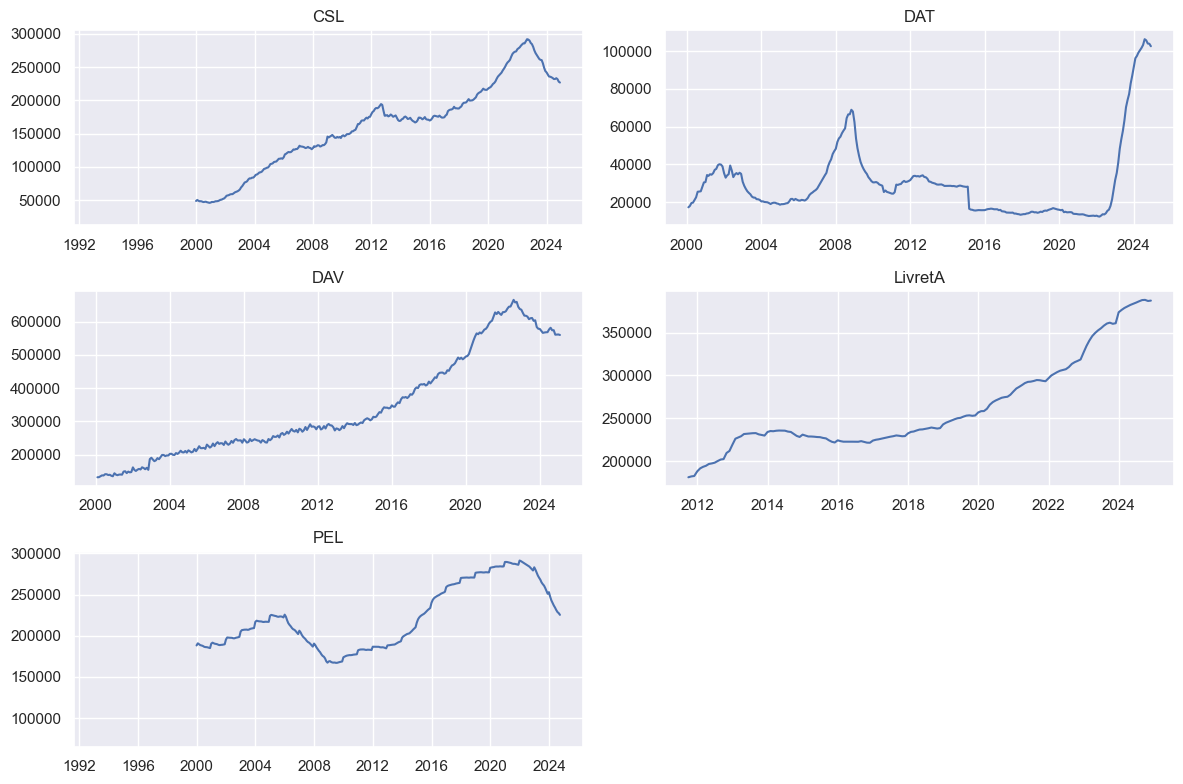

In [159]:
plt.figure(figsize=(12, 8))
for i, column in enumerate(df_y.columns):
    plt.subplot(3, 2, i + 1)
    plt.plot(df_y[column], label=column)
    plt.title(column)   
plt.tight_layout()

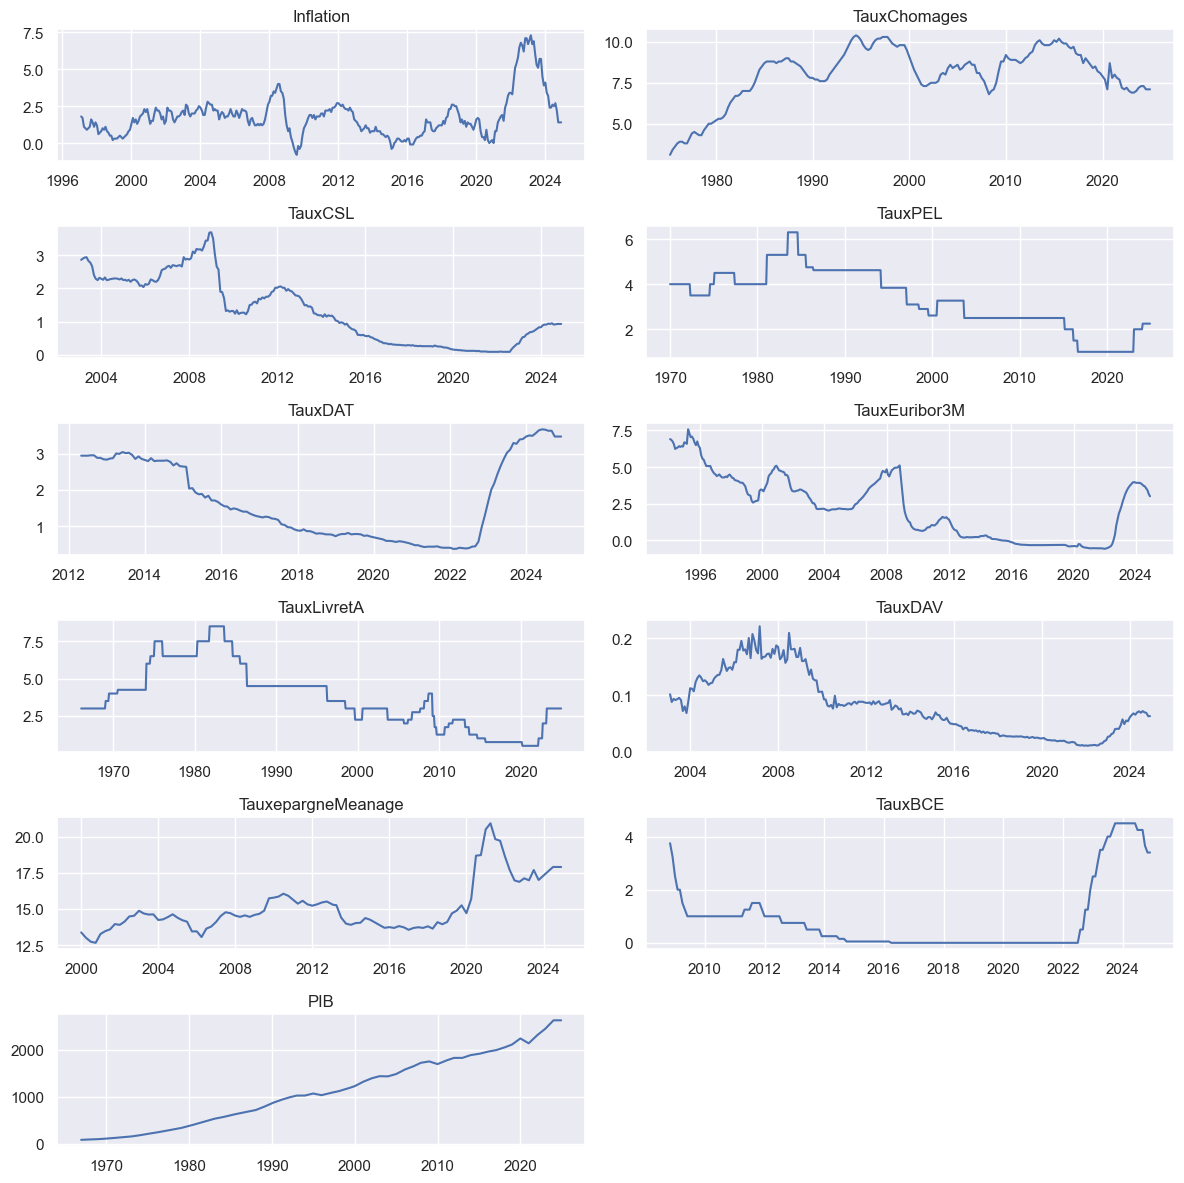

In [160]:
names_exo = ['Inflation', 'TauxChomages', 'TauxCSL', 'TauxPEL', 
             'TauxDAT', 'TauxEuribor3M', 'TauxLivretA', 'TauxDAV',
             'TauxepargneMeanage', 'TauxBCE']

list_df_exo = []

for name in names_exo:
    path = os.path.join(file, f'{name}.csv')
    df = pd.read_csv(path, index_col=0, parse_dates=True, sep=";")
    df.index.name = 'date'

    df = df.replace("-", np.nan)
    df = df.map(lambda x: str(x).replace(",", ".")).astype(float).sort_index()
    df.columns = [name]
    
    list_df_exo.append(df)
    
df_exo = pd.concat(list_df_exo[:-1], axis=1)
df_exo = df_exo.interpolate(method='time')
df_exo = df_exo.join(list_df_exo[-1])

df_macro = pd.read_csv('data/macroeconomie.csv', index_col=0, parse_dates=True, sep=";")
df_macro.rename(columns={'France, PIB en PPA': 'PIB'}, inplace=True)
df_macro['PIB'] = df_macro['PIB'].str.replace(',', '.').astype(float)
df_exo = df_exo.join(df_macro['PIB'], how='left')

df_exo['PIB'] = df_exo['PIB'].interpolate(method='time')

plt.figure(figsize=(12, 12))
for i, column in enumerate(df_exo.columns):
    plt.subplot(6, 2, i + 1)
    plt.plot(df_exo[column], label=column)
    plt.title(column)
plt.tight_layout()
plt.show()

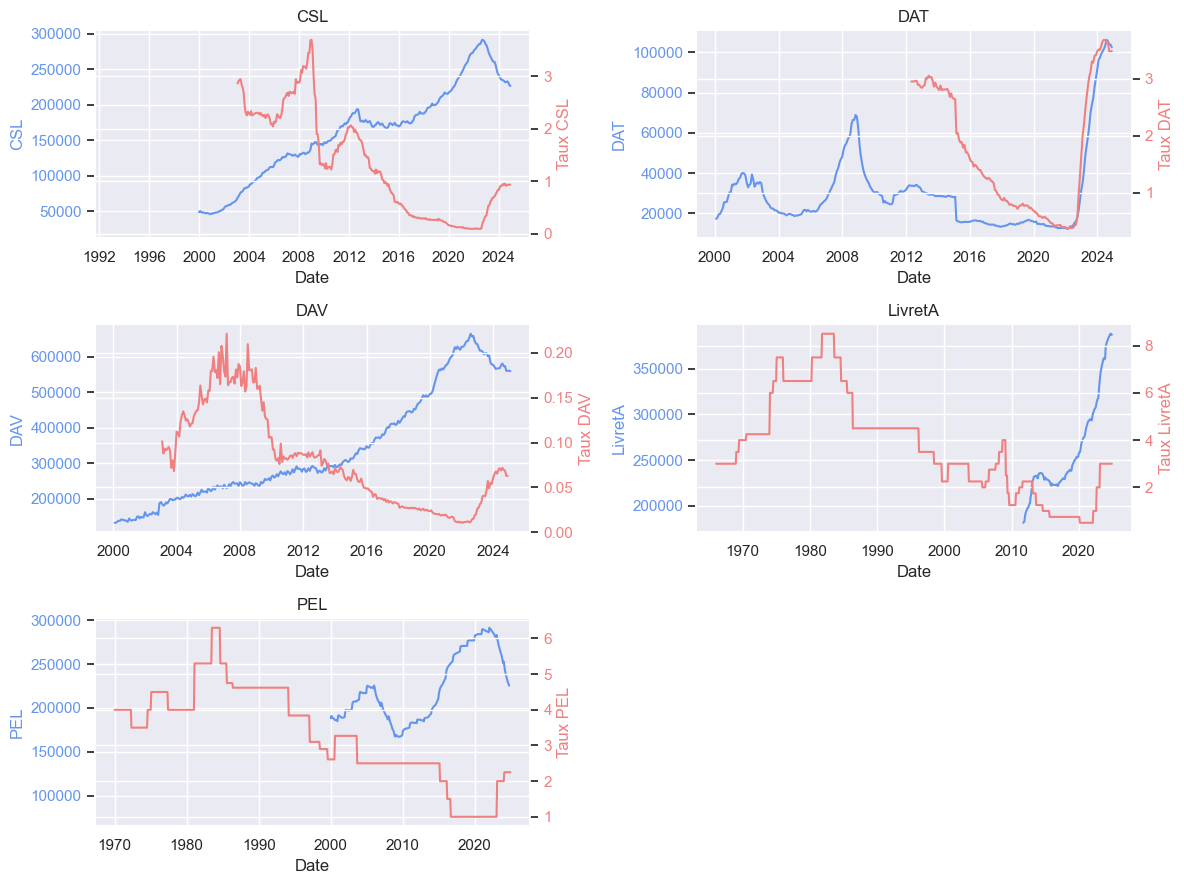

In [161]:
fig, axs = plt.subplots(3, 2, figsize=(12, 9))
axs = axs.flatten()  # Flatten the 2D array of axes to 1D for easier indexing

for i, col in enumerate(df_y.columns):
    ax1 = axs[i]
    
    # Plot the df_y series on the left y-axis with a softer blue
    ax1.plot(df_y[col], color='cornflowerblue', label=col)
    ax1.set_xlabel('Date')
    ax1.set_ylabel(col, color='cornflowerblue')
    ax1.tick_params(axis='y', labelcolor='cornflowerblue')
    
    # Create a twin axis and plot the df_exo series with a softer red on the right
    ax2 = ax1.twinx() 
    ax2.plot(df_exo[f'Taux{col}'], color='lightcoral', label=f'Taux {col}')
    ax2.set_ylabel(f'Taux {col}', color='lightcoral')
    ax2.tick_params(axis='y', labelcolor='lightcoral')
    
    ax1.set_title(col)

# Hide any unused subplots
for j in range(i+1, len(axs)):
    axs[j].set_visible(False)

fig.tight_layout()
plt.show()

## Saving raw data

In [162]:
df_y.to_csv(os.path.join(file, 'raw', 'y.csv'))
df_exo.to_csv(os.path.join(file, 'raw', 'exo.csv'))

## Range of data availability

In [163]:
min_date = pd.concat([df_y, df_exo], axis=1).dropna().index.min()
min_date

Timestamp('2012-04-30 00:00:00')

In [164]:
max_date = pd.concat([df_y, df_exo], axis=1).dropna().index.max()
max_date

Timestamp('2024-09-30 00:00:00')

Adjusting the date

In [165]:
df_y = df_y.loc[min_date:max_date]
df_exo = df_exo.loc[min_date:max_date]

df_y.shape, df_exo.shape

((150, 5), (152, 11))

In [166]:
y_dates = set(df_y.index)
exo_dates = set(df_exo.index)

missing_in_y = exo_dates - y_dates
missing_in_exo = y_dates - exo_dates

print("Dates in y but not in exo:", missing_in_exo)
print("Dates in exo but not in y:", missing_in_y)

Dates in y but not in exo: set()
Dates in exo but not in y: {Timestamp('2024-03-30 00:00:00'), Timestamp('2023-12-30 00:00:00')}


In [167]:
df_exo['2024-02-01':'2024-05-31']

,Inflation,TauxChomages,TauxCSL,TauxPEL,TauxDAT,TauxEuribor3M,TauxLivretA,TauxDAV,TauxepargneMeanage,TauxBCE,PIB
date,,,,,,,,,,,
2024-02-29,3.200000,7.300000,0.91,2.25,3.500000,3.923200,3.0,0.067700,17.501099,4.5,2626.98
2024-03-30,2.425806,7.300000,0.91,2.25,3.567742,3.922426,3.0,0.065377,17.600000,4.5,2626.98
2024-03-31,2.400000,7.300000,0.91,2.25,3.570000,3.922400,3.0,0.065300,17.603261,4.5,2626.98
2024-04-30,2.400000,7.234066,0.94,2.25,3.650000,3.886400,3.0,0.069400,17.701087,4.5,2626.98
2024-05-31,2.600000,7.165934,0.93,2.25,3.680000,3.813700,3.0,0.071300,17.802174,4.5,2626.98


Repetitive month

In [168]:
monthly_index = pd.date_range(min_date, max_date, freq='M')
df_y = df_y.reindex(monthly_index)
df_exo = df_exo.reindex(monthly_index)

df_y = df_y.interpolate(method='time')
df_exo = df_exo.interpolate(method='time')

df_y.to_csv(os.path.join(file, 'normal', 'y.csv'))
df_exo.to_csv(os.path.join(file, 'normal', 'exo.csv'))

## Smooth data

In [169]:
names_y = ['CSL', 'DAT', 'DAV', 'LivretA', 'PEL']
file = "data2"


list_df = []

for name in names_y:
    
    path = os.path.join(file, f'{name}.csv')
    df = pd.read_csv(path, index_col=0, parse_dates=True, sep=";")
    df.index.name = 'date'

    df = df.replace("-", np.nan)
    df = df.map(lambda x: str(x).replace(",", ".")).astype(float).sort_index()
    df.columns = [name]
    
    list_df.append(df)
df_y = pd.concat(list_df, axis=1)

In [170]:
names_exo = ['Inflation', 'TauxChomages', 'TauxCSL', 'TauxPEL', 
             'TauxDAT', 'TauxEuribor3M', 'TauxLivretA', 'TauxDAV',
             'TauxepargneMeanage', 'TauxBCE']

list_df_exo = []

for name in names_exo:
    path = os.path.join(file, f'{name}.csv')
    df = pd.read_csv(path, index_col=0, parse_dates=True, sep=";")
    df.index.name = 'date'

    df = df.replace("-", np.nan)
    df = df.map(lambda x: str(x).replace(",", ".")).astype(float).sort_index()
    df.columns = [name]
    
    list_df_exo.append(df)
    
df_exo = pd.concat(list_df_exo[:-1], axis=1)
df_exo = df_exo.interpolate(method='time')
df_exo = df_exo.join(list_df_exo[-1])

df_macro = pd.read_csv('data/macroeconomie.csv', index_col=0, parse_dates=True, sep=";")
df_macro.rename(columns={'France, PIB en PPA': 'PIB'}, inplace=True)
df_macro['PIB'] = df_macro['PIB'].str.replace(',', '.').astype(float)
df_exo = df_exo.join(df_macro['PIB'], how='left')

df_exo['PIB'] = df_exo['PIB'].interpolate(method='time')

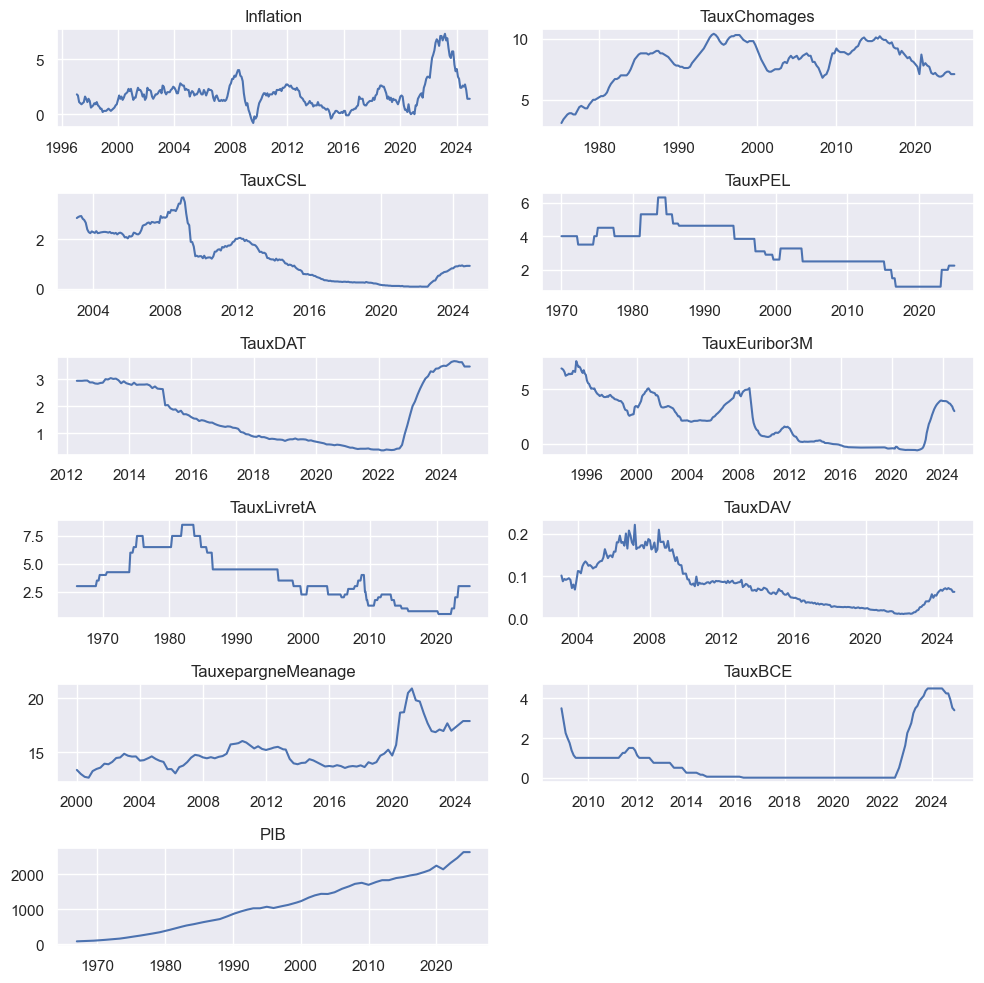

In [171]:
will_smooth = True
window = 2

if will_smooth:

    names_exo = ['Inflation', 'TauxChomages', 'TauxCSL', 'TauxPEL', 
                'TauxDAT', 'TauxEuribor3M', 'TauxLivretA', 'TauxDAV',
                'TauxepargneMeanage', 'TauxBCE']

    list_df_exo = []

    for name in names_exo:
        path = os.path.join('data', f'{name}.csv')
        df = pd.read_csv(path, index_col=0, parse_dates=True, sep=";")
        df.index.name = 'date'

        df = df.replace("-", np.nan)
        df = df.map(lambda x: str(x).replace(",", ".")).astype(float).sort_index()
        df.columns = [name]
        
        list_df_exo.append(df)
        
    df_exo = pd.concat(list_df_exo[:-1], axis=1)
    df_exo = df_exo.interpolate(method='time')
    df_exo = df_exo.join(list_df_exo[-1])
    
    df_macro = pd.read_csv('data/macroeconomie.csv', index_col=0, parse_dates=True, sep=";")
    df_macro.rename(columns={'France, PIB en PPA': 'PIB'}, inplace=True)
    df_macro['PIB'] = df_macro['PIB'].str.replace(',', '.').astype(float)
    df_exo = df_exo.join(df_macro['PIB'], how='left')

    df_exo['PIB'] = df_exo['PIB'].interpolate(method='time')
        
    columns_to_smooth = ['TauxPEL', 'TauxLivretA', 'TauxBCE']
    for column in columns_to_smooth:
        df_exo[column] = df_exo[column].rolling(window).mean()
            
    plt.figure(figsize=(10, 10))
    for i, column in enumerate(df_exo.columns):
        plt.subplot(6, 2, i + 1)
        plt.plot(df_exo[column], label=column)
        plt.title(column)
    plt.tight_layout()
    plt.show()

In [172]:
min_date = pd.concat([df_y, df_exo], axis=1).dropna().index.min()
min_date
max_date = pd.concat([df_y, df_exo], axis=1).dropna().index.max()
df_y = df_y.loc[min_date:max_date]
df_exo = df_exo.loc[min_date:max_date]

monthly_index = pd.date_range(min_date, max_date, freq='M')
df_y = df_y.reindex(monthly_index)
df_exo = df_exo.reindex(monthly_index)

df_y_smooth = df_y.interpolate(method='time')
df_exo_smooth = df_exo.interpolate(method='time')

df_y_smooth.to_csv(os.path.join(file, 'smooth', 'y.csv'))
df_exo_smooth.to_csv(os.path.join(file, 'smooth', 'exo.csv'))

## Transforming data to weights

In [173]:
file = 'data2'
df_y = pd.read_csv(os.path.join(file, 'smooth', 'y.csv'), index_col=0, parse_dates=True)
df_exo = pd.read_csv(os.path.join(file, 'smooth', 'exo.csv'), index_col=0, parse_dates=True)
df_y.index.name = 'date'
df_exo.index.name = 'date'
#df_y = df_y.div(df_y.sum(axis=1), axis=0)

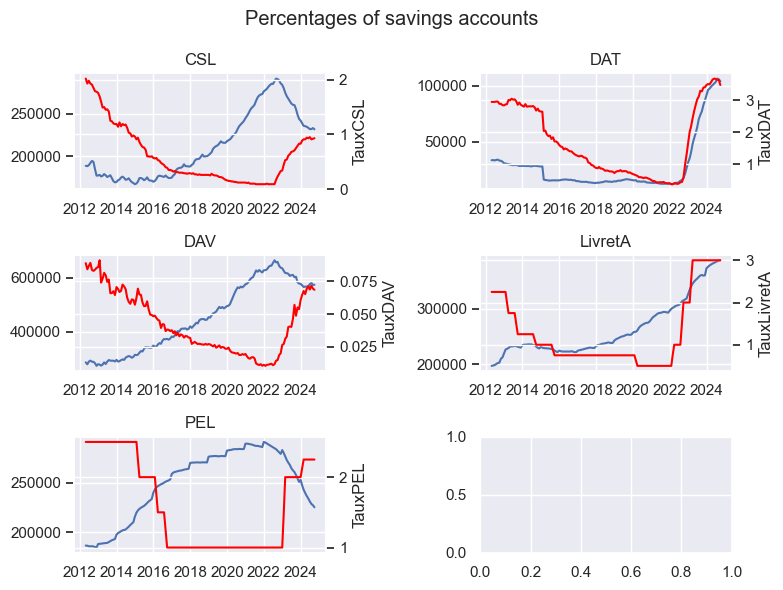

In [174]:
fig, ax = plt.subplots(3, 2, figsize=(8, 6))
fig.suptitle("Percentages of savings accounts")
for i, name in enumerate(df_y.columns):
    
    y = df_y[name]
    exo = df_exo[  list( filter( lambda x: name in x, df_exo.columns ) )[0]  ]
    
    row, col = divmod(i, 2)
    ax[row, col].plot(y, label=name)
    ax[row, col].set_title(name)
    
    ax2 = ax[row, col].twinx()
    ax2.plot(exo, color='red', label=exo.name)
    ax2.set_ylabel(exo.name)

fig.tight_layout()
plt.show()

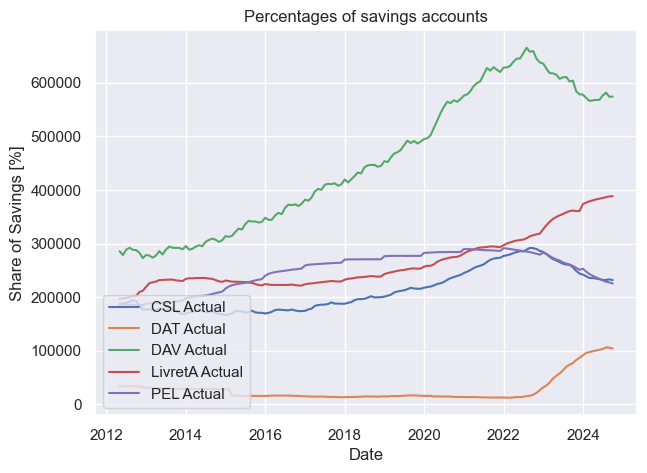

In [175]:
plt.title(f"Percentages of savings accounts")
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"] # for styling

for i, col in enumerate(df_y.columns):
    plt.plot(df_y.index, df_y[col], label=f"{col} Actual", color=colors[i % len(colors)])
plt.legend(loc='lower left')
plt.ylabel("Share of Savings [%]")
plt.xlabel("Date")
plt.show()

# Checking stationarity

In [176]:
stationarity_dict = check_stationarity(df_y, significance=0.05)

print("Stationarity of time series:")
for key, value in stationarity_dict.items():
    print(f"{key}: {value}")

Stationarity of time series:
CSL: I(3)
DAT: I(2)
DAV: I(2)
LivretA: I(2)
PEL: I(3)


The time series are stationary but at second degree (that is, we have to differentiate twice to make them stationary).

### Structural break after 2022 

In [177]:
structural_break_date = pd.to_datetime("2022-01-01")

stationarity_dict = check_stationarity(df_y.loc[:structural_break_date], 
                                       significance=0.05)

print("Stationarity before the break:")
for key, value in stationarity_dict.items():
    print(f"{key}: {value}")

Stationarity before the break:
CSL: I(2)
DAT: I(1)
DAV: I(2)
LivretA: I(3)
PEL: I(0)


We can clearly appreciate that the time series are well behaved before the structural break. 

# SARIMAX model

In [178]:
df_exo.columns

Index(['Inflation', 'TauxChomages', 'TauxCSL', 'TauxPEL', 'TauxDAT',
       'TauxEuribor3M', 'TauxLivretA', 'TauxDAV', 'TauxepargneMeanage',
       'TauxBCE', 'PIB'],
      dtype='object')

Train size: 114

Fitting SARIMA for CSL
Stationarity for CSL: {'CSL': 'I(3)'}
Fitting without exogenous variables for CSL
Best model for CSL is: (0, 3, 0), seasonal_order=(0, 0, 0, 0)
MAPE for CSL: 163.788%

Fitting SARIMA for DAT
Stationarity for DAT: {'DAT': 'I(2)'}
Fitting without exogenous variables for DAT
Best model for DAT is: (2, 2, 2), seasonal_order=(0, 0, 0, 0)
MAPE for DAT: 166.086%

Fitting SARIMA for DAV
Stationarity for DAV: {'DAV': 'I(2)'}
Fitting without exogenous variables for DAV
Best model for DAV is: (2, 2, 2), seasonal_order=(0, 0, 0, 0)
MAPE for DAV: 8.407%

Fitting SARIMA for LivretA
Stationarity for LivretA: {'LivretA': 'I(2)'}
Fitting without exogenous variables for LivretA
Best model for LivretA is: (2, 3, 0), seasonal_order=(0, 0, 0, 0)
MAPE for LivretA: 4830.363%

Fitting SARIMA for PEL
Stationarity for PEL: {'PEL': 'I(3)'}
Fitting without exogenous variables for PEL
Best model for PEL is: (0, 2, 0), seasonal_order=(0, 0, 0, 0)
MAPE for PEL: 6.652%


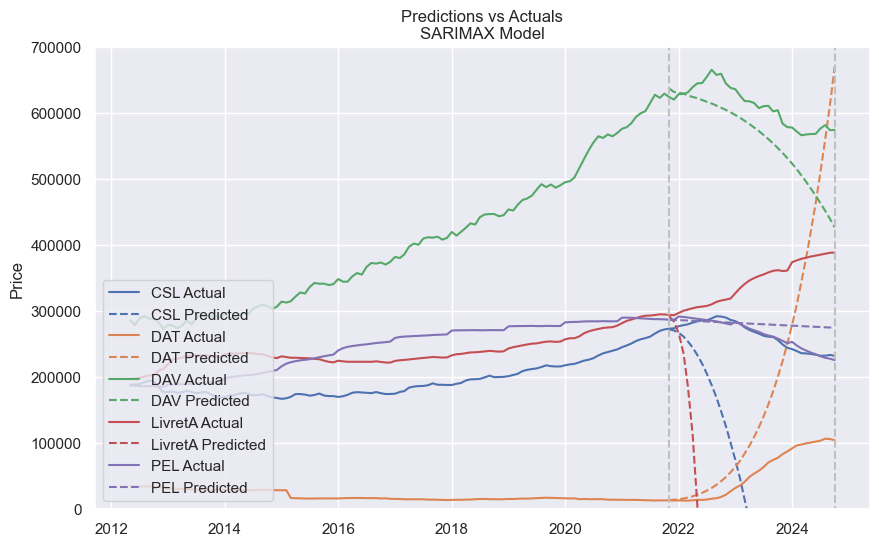

In [191]:
# We can arbitrarily choose the exogenous variables.
X = df_exo[['TauxCSL', 'TauxLivretA', 
            'TauxDAT', 'TauxPEL', 'TauxDAV',
            'TauxEuribor3M', 'Inflation',
            'TauxChomages', 'PIB']].copy()

y = df_y.copy()

test_size = 36

sarima_params = {
    'CSL': {'d': 3,     'auto_order' : True ,'seasonal': False, 'm': 3, 'p': 2, 'q': 2},
    'DAT': {'d': 2,     'auto_order' : True ,'seasonal': False, 'm': 3, 'p': 2, 'q': 2},
    'DAV': {'d': 2,     'auto_order' : True ,'seasonal': False, 'm': 3, 'p': 2, 'q': 2},
    'PEL': {'d': 2,     'auto_order' : True ,'seasonal': False, 'm': 3, 'p': 2, 'q': 2},
    'LivretA': {'d': 3, 'auto_order' : True ,'seasonal': False, 'm': 3, 'p': 2, 'q': 2},
}

model, forecast, errors = sarima_model_multivariate(y, X,
                        test_size=test_size,
                        sarima_params=sarima_params,
                        stationary_exog=False,
                        title="SARIMAX Model",
                        save_img=False, save_txt=False,
                        data_percentage=False,
                        )

# ARDL - Auto-regressive distributed lag model


The model is a econometric model used to analyze the dynamic relationship between dependent variable and one or more explanatory variables, while incorporating both their current and lagged values. It is particulary useful when variables are a mix of I(0), I(1) (non-stationary) but not I(2) variables. 

1. Formula: 

$$Y_t = c + ∑(ϕ_i Y_{t-i}) + ∑(∑(β_{j,m} X_{j,t-m})) + ε_t$$

a single explanatory variable $X_t$, ARDL(p,q) model is:

$$Y_t = c + ∑(ϕ_i Y_{t-i}) + ∑(β_m X_{t-m}) + ε_t$$

2. Intuition

    1. Combines lagged effects
    2. Short term and long term relationship: short in lagged terms and long-term from equilibrium relationship between variables
    3. Flexibility with mixed integration orders
    4. Error correction mechanism
    
3. Steps

    1. Check order of integration. non $I(2)$
    2. Lag selection: AIC, BIC, HQIC
    3. Estimate the model
    4. Test for cointegration. Bounds test, check for presence of long-term relationship
    5. Transform into ECM (if cointegration exists): rewrite the model in ECM
    
**Assumptions**

1. Stationary residuals
2. No $I(2)$ variables. That must be $I(0)$ or $I(1)$
3. Linear relationship between variables
4. Exogeneity of explanatory variables
5. Sufficient Data length

**Limitations**

1. Dependent on lag selection
2. Non-linear relationships
3. Bound test limitations (not robust for small samples)
4. Model complexity
5. Endogeneity: weak exogeneity of regressor.

**Applications**

1. Finance 
    1. Asset pricing.
    2. Volatility modeling
    3. Exchange rates
    
2. Macroeconomics
    1. Monetary policy
    2. Trade analysis
    3. Consumption and saving
    

The model automatically transform the data to the difference form, performs the model and then reconstruct to the orginal form.

Fitting ARDL for CSL
{'CSL': 'I(3)'}
MAPE for CSL: 62.416%
Fitting ARDL for DAT
{'DAT': 'I(2)'}
MAPE for DAT: 38.336%
Fitting ARDL for DAV
{'DAV': 'I(2)'}
MAPE for DAV: 63.591%
Fitting ARDL for LivretA
{'LivretA': 'I(2)'}
MAPE for LivretA: 34.005%
Fitting ARDL for PEL
{'PEL': 'I(3)'}
MAPE for PEL: 21.029%


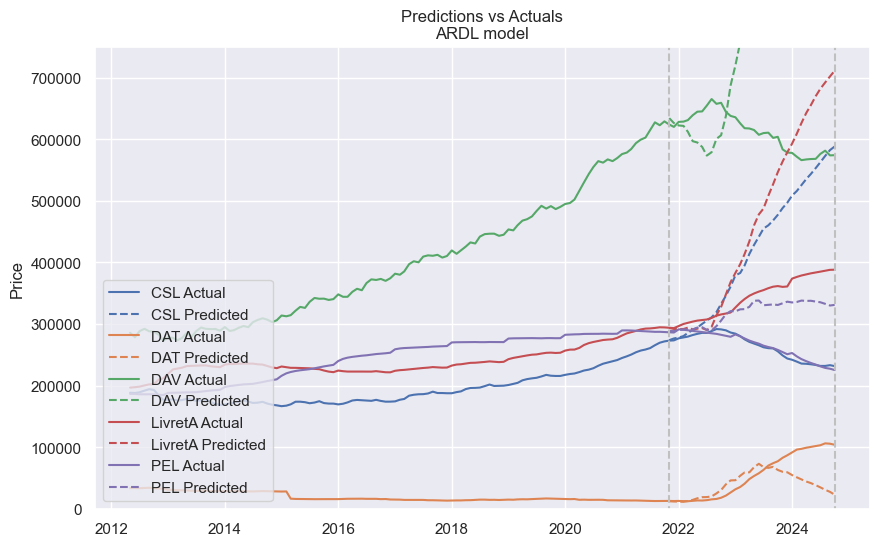

In [ ]:
# We can arbitrarily choose the exogenous variables.
X = df_exo[['TauxCSL', 'TauxLivretA', 
            'TauxDAT', 'TauxPEL', 'TauxDAV',
            'TauxEuribor3M']].copy()
            
X = df_exo.copy()
y = df_y.copy()

test_size = 36
model_1, result_1 = ardl_model_multivariate(X, y, test_size,
                                            max_lag_y = 6,
                                            max_lag_exog=3,
                                            trend='c',
                                            title="ARDL model",
                                            data_percentage=False,)

We can extend the exogenous variable to have long range forecasting.

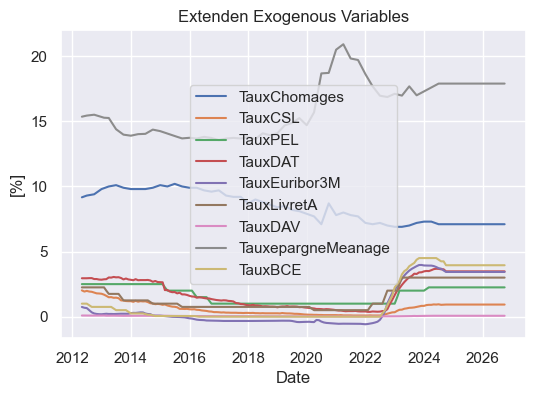

In [181]:
projector = ExogenousProjector(X)

# Option 1: Extend by specifying the number of periods (e.g., 12 months) with a month-end frequency.
extended_X = projector.extend(periods=24, freq='ME')
X_fixed = pd.concat([X, extended_X], axis=0)

plt.figure(figsize=(6, 4))
for i, col in enumerate(X_fixed.columns):
    if "Taux" in col:
        plt.plot(X_fixed.index, X_fixed[col], label=col)
plt.ylabel("[%]")
plt.xlabel("Date")
plt.title("Extenden Exogenous Variables")
plt.legend()
plt.show()

Fitting ARDL for CSL
{'CSL': 'I(3)'}
MAPE for CSL: 71.799%
Fitting ARDL for DAT
{'DAT': 'I(2)'}
MAPE for DAT: 258.753%
Fitting ARDL for DAV
{'DAV': 'I(2)'}
MAPE for DAV: 25.214%
Fitting ARDL for LivretA
{'LivretA': 'I(2)'}
MAPE for LivretA: 24.043%
Fitting ARDL for PEL
{'PEL': 'I(3)'}
MAPE for PEL: 20.46%


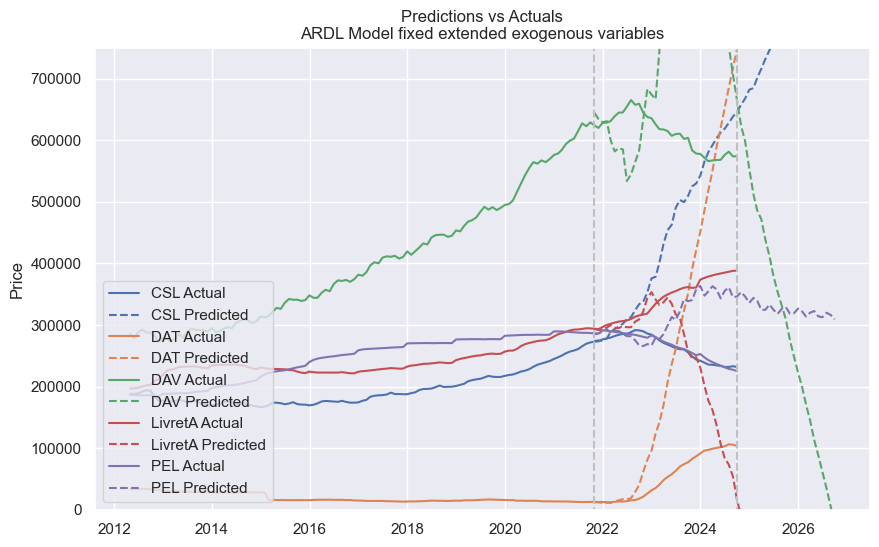

In [205]:
extended_exo = projector.extend(periods=24, freq='ME')
X_fixed = pd.concat([X, extended_exo], axis=0)

model_2, results_2 = ardl_model_multivariate(
    X_fixed, y, test_size, 
    max_lag_y=6, 
    max_lag_exog=6,
    trend='c', title="ARDL Model fixed extended exogenous variables",
    data_percentage=False,)

To the extended exogenous variables we can add a shock.

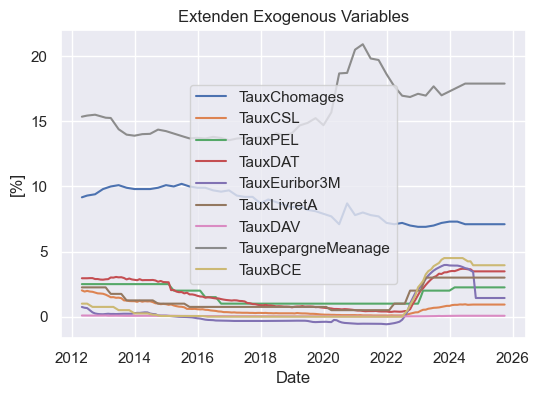

In [183]:
shock = {'TauxEuribor3M': -2}
projected_shocked_exo = projector.project_and_shock(periods=12, freq='ME', shock_dict=shock, shock_type='additive')
X_shock = pd.concat([X, projected_shocked_exo], axis=0)

plt.figure(figsize=(6, 4))
for i, col in enumerate(X_shock.columns):
    if "Taux" in col:
        plt.plot(X_shock.index, X_shock[col], label=col)
plt.ylabel("[%]")
plt.xlabel("Date")
plt.title("Extenden Exogenous Variables")
plt.legend()
plt.show()

Fitting ARDL for CSL
{'CSL': 'I(3)'}
MAPE for CSL: 61.603%
Fitting ARDL for DAT
{'DAT': 'I(2)'}
MAPE for DAT: 67.51%
Fitting ARDL for DAV
{'DAV': 'I(2)'}
MAPE for DAV: 203.871%
Fitting ARDL for LivretA
{'LivretA': 'I(2)'}
MAPE for LivretA: 13.537%
Fitting ARDL for PEL
{'PEL': 'I(3)'}
MAPE for PEL: 5.331%


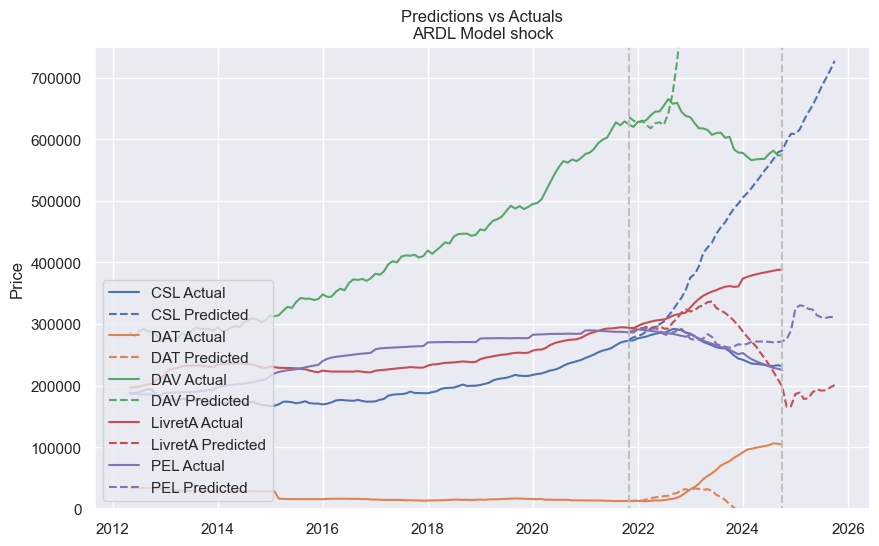

In [207]:
model_3, results_3 = ardl_model_multivariate(X_shock, y, test_size, 
                                             max_lag_y=6, 
                                             max_lag_exog=2, 
                                             trend='c', 
                                             title="ARDL Model shock",
                                             data_percentage=False,)

## ECM error correlation model

Used to model dynamic relationships between time series while explicitly taking into account the long-run equilibrium relationships between them. It is a special case of VAR. It is employed when the variables are cointegrated.(i.e. they have a stable, long-term relationship despite being non-stationary individually).

There is only one target variable. It focuses in co-integration. there is no symmetry in variables.

$$ΔY_t = α + βΔX_t + γEC_t-1 + ε_t$$

$$EC_{t-1} = Y_{t-1} - \beta_0 - \beta_1X_{t-1}$$

EC measures how far the system is from the equilibrium relationship.

**Assumptions**

1. Cointegration: variables are non-stationary I(1) but have a stable long-term relationship.
2. Stationarity differences: first difference is stationary.
3. Linearity
4. White noise error
5. Exogeneity: $X_t$ is weakly exogenous

**Limitations** 

1. Assumes cointegration
2. Linearity
3. Limited short-term modeling
4. sensitivity to specifications
5. Small sample bias: ecm models can suffer from inefficiency and instability in small datasets

**Applications**

1. Macroeconomics
2. Finance. stock price adjustments.
3. Energy economics
4. Policy analysis. short term shocs affect long term economic
5. international trade


**How to identify cointegration** 

There are statistical tests. They measures long term relationships between non-stationary variables.

1. Engle-Granger test
    1. Uses OLS to estimate relationships.
    2. Test for stationarity of residuals.
  
2. Johansen test



Lets check the cointegration of the variables. We can use the Johansen test. It is a multivariate test that allows us to check for multiple cointegrating relationships between several time series. 

Since there is a structural break in the data, lets see if the test perceives it.

In [185]:
break_date = pd.Timestamp('2022-01-01')
data = df_y.loc[:break_date].copy()
coint_term = johansen_cointegration_test(data)

Johansen Cointegration Test Results:
Rank 0: Trace Stat = 79.9367339714984, Critical Value (5%) = 69.8189
Rank 1: Trace Stat = 44.935726913697295, Critical Value (5%) = 47.8545
Rank 2: Trace Stat = 26.01759055802785, Critical Value (5%) = 29.7961
Rank 3: Trace Stat = 9.673426947453818, Critical Value (5%) = 15.4943
Rank 4: Trace Stat = 0.4480445687057911, Critical Value (5%) = 3.8415
Number of cointegrating relationships: 1


In [186]:
coint_term = johansen_cointegration_test(df_y)

Johansen Cointegration Test Results:
Rank 0: Trace Stat = 122.64385760083272, Critical Value (5%) = 69.8189
Rank 1: Trace Stat = 66.48207243851166, Critical Value (5%) = 47.8545
Rank 2: Trace Stat = 32.433832698031, Critical Value (5%) = 29.7961
Rank 3: Trace Stat = 13.22853532055591, Critical Value (5%) = 15.4943
Rank 4: Trace Stat = 4.0917260492602985, Critical Value (5%) = 3.8415
Number of cointegrating relationships: 4


The test is highly dependent of the initial conditions.

Lets check if the differentiate

In [187]:
break_date = pd.Timestamp('2022-01-01')
data = df_y.loc[:break_date].copy()
coint_term = johansen_cointegration_test(data.diff().dropna())

Johansen Cointegration Test Results:
Rank 0: Trace Stat = 219.49939301309874, Critical Value (5%) = 69.8189
Rank 1: Trace Stat = 134.90834309264412, Critical Value (5%) = 47.8545
Rank 2: Trace Stat = 80.09692445910683, Critical Value (5%) = 29.7961
Rank 3: Trace Stat = 38.815020070528384, Critical Value (5%) = 15.4943
Rank 4: Trace Stat = 6.901809369430197, Critical Value (5%) = 3.8415
Number of cointegrating relationships: 5


In [188]:
coint_term = johansen_cointegration_test(df_y.diff().dropna())

Johansen Cointegration Test Results:
Rank 0: Trace Stat = 246.10934002259629, Critical Value (5%) = 69.8189
Rank 1: Trace Stat = 137.2384419702329, Critical Value (5%) = 47.8545
Rank 2: Trace Stat = 75.62429839865656, Critical Value (5%) = 29.7961
Rank 3: Trace Stat = 34.93253355325085, Critical Value (5%) = 15.4943
Rank 4: Trace Stat = 4.755256687122415, Critical Value (5%) = 3.8415
Number of cointegrating relationships: 5


Mean absolute percentage error: 21.793 %


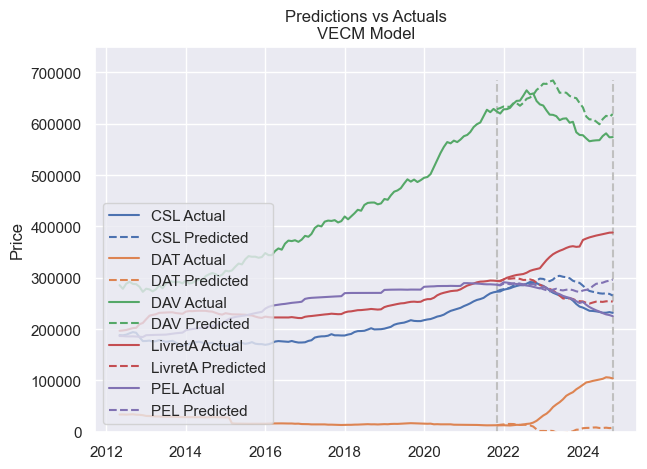

In [258]:
y = df_y.copy()
X = df_exo[[
    'TauxCSL', 'TauxLivretA', 'TauxDAT', 'TauxPEL', 'TauxEuribor3M',
    'TauxDAV', 'PIB', 'TauxChomages',
]].copy()


# This is highly dependent of the parameters.
# With most of them, it gives error.

optimal_lag_endog = 6
best_lag_exog = 1
coint_rank = 5
difference = True

model_4, results_4 = vecm_model_vanilla(
    X, y, test_size, 
    optimal_lag_endog=optimal_lag_endog, 
    best_lag_exog=best_lag_exog,
    coint_rank=coint_rank,
    difference=difference,
    title="VECM Model",
    data_percentage=False,
)